#### Importa os pacotes e funções

In [31]:
from tools.functions import *

#### Parâmetros

In [32]:
base_path       = 'img'
dataset_path    = f'{base_path}/dataset/pre_processada/gray/'
train_ratio     = [0.75, 0.8, 0.85, 0.9]
thresh_normalization = 0.500
# thresh_normalization = 10.0

# Specify the threshold to consider grains with defects
thresh_good     = [0.00, 0.10, 0.15]
iterations      = range(1, 6)

classification_types = {'n_grains': ['50', '60', '70', '80', '90', '100'], 'defect_stratified': ['0%', '10%', '15%', '20%', '25%', '30%'], 'defect_thresholded': ['Com defeitos', 'Sadios']}

x_label = 'Predito'
y_label = 'Verdadeiro'



In [33]:
# Read all image filenames in the directory specified in dataset_path
image_filenames = read_all_images_filenames(dataset_path)

df_train                    = pd.DataFrame()
df_test                     = pd.DataFrame()
df_train_model              = pd.DataFrame()
classification_results_df   = pd.DataFrame()

classification_metrics_results = {
    ratio: {
        thresh: {
            classification_type: {} for classification_type in classification_types
        } for thresh in thresh_good
    } for ratio in train_ratio
}

confusion_matrices = {
    ratio: {
        thresh: {
            classification_type: {} for classification_type in classification_types
        } for thresh in thresh_good
    } for ratio in train_ratio
}

In [34]:
# Perform the procedure for all specified training/testing percentages, thresholds to consider good grains, and the number of iterations for each set
for ratio in train_ratio:           
    for thresh in thresh_good:
        for iteration in iterations:

            df_train                    = pd.DataFrame()
            df_test                     = pd.DataFrame()
            df_train_model              = pd.DataFrame()

            # Divide the dataset into train and test sets with the specified ratio
            train_filenames, test_filenames = divide_dataset(image_filenames, ratio)

            # Create dataframes for the train and test sets using the filenames and images in the specified directory
            df_train = create_dataframes(train_filenames, dataset_path)
            df_test = create_dataframes(test_filenames, dataset_path)

            # Normalize the 'ratio_80a255_por_1a80' feature in the train and test datasets. The normalization threshold is specified
            df_train, df_test = normalize_dataset(df_train, df_test, 'ratio_80a255_por_1a80', thresh_normalization)

            # Summarize the train dataframe by grouping it by qtde_graos and percentual_defeitos and calculating summary statistics to generate the model
            df_train_model = summarize_train_data(df_train)

            # Call the function to calculate the average number of pixels per grain for the training dataset
            avg_pixels_1a255_per_grain = calculate_avg_pixels_per_grain(df_train)

            # Calculate number of grains
            df_test['qtde_graos_calculado'] = df_test['npixels_1a255'].apply(calculate_number_of_grains, grain_avg = avg_pixels_1a255_per_grain)

            # Estimate number of grains (in discrete values predefined)
            df_test['qtde_graos_estimado'] = df_test['qtde_graos_calculado'].apply(estimate_number_of_grains)

            # Calculate the error between the actual and estimated values for the quantity of grains
            df_test['erro_graos'] = df_test['qtde_graos_estimado'] - df_test['qtde_graos']

            # Estimate the percentage of defects in the test dataset based on the number of grains and ratio
            df_test['percentual_defeitos_estimado'] = df_test.apply(lambda row: estimate_defect_percentage(row['qtde_graos'], 
                                                                                                           row['ratio_80a255_por_1a80_normalizado'], df_train_model), axis=1)

            # Calculate the error in the estimated defect percentage
            df_test['erro_defeitos'] = df_test['percentual_defeitos_estimado'] - df_test['percentual_defeitos']

            # Select only the columns of interest to create a summarized dataframe with the classification results
            classification_results_df = df_test[['qtde_graos', 'percentual_defeitos', 'qtde_graos_estimado', 'percentual_defeitos_estimado', 'erro_graos']].copy()

            # Check the quality (healthy or defective) according to the parameterized threshold
            classification_results_df['qualidade'] = (classification_results_df['percentual_defeitos'].apply(check_quality, thresh)).astype(int)
            classification_results_df['qualidade_estimado'] = (classification_results_df['percentual_defeitos_estimado'].apply(check_quality, thresh)).astype(int)
            
            # Iterate over each classification type and get the classification results
            for classification_type in classification_types:

                cm, cr = generate_confusion_matrix_and_classification_metrics(classification_results_df, classification_types[classification_type], classification_type)
                
                # Update the confusion matrix and classification metrics dictionaries
                confusion_matrices[ratio][thresh][classification_type].update({iteration: cm})
                classification_metrics_results[ratio][thresh][classification_type].update({iteration: cr})


# Apply a cross-validation by taking the average of the results obtained in each iteration
classification_metrics_results, confusion_matrices = cross_validation(train_ratio, thresh_good, classification_types, 
                                                                      iterations, classification_metrics_results, confusion_matrices)

export_all_confusion_matrices_images(train_ratio, thresh_good, classification_types, iterations, confusion_matrices, base_path, [x_label, y_label])

### Matrizes de confusão (média) para quantidade de grãos

In [43]:
# cm = confusion_matrices[train_ratio[0]][thresh_good[1]]['n_grains']['mean']
# display(cm)
# export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_075_ngrains.pdf', [x_label, y_label])

# cm = confusion_matrices[train_ratio[1]][thresh_good[1]]['n_grains']['mean']
# # display(cm)
# export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_080_ngrains.pdf', [x_label, y_label])

# cm = confusion_matrices[train_ratio[2]][thresh_good[1]]['n_grains']['mean']
# # display(cm)
# export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_085_ngrains.pdf', [x_label, y_label])

# cm = confusion_matrices[train_ratio[3]][thresh_good[1]]['n_grains']['mean']
# # display(cm)
# export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_090_ngrains.pdf', [x_label, y_label])





# cm = confusion_matrices[train_ratio[0]][thresh_good[0]]['defect_stratified']['mean']
# display(cm)
# export_confusion_matrix_as_image(cm, classification_types['defect_stratified'], r'img\confusion_matrix\defect_stratified\resumidas\cm_075_defect_stratified.pdf', [x_label, y_label])

# cm = confusion_matrices[train_ratio[1]][thresh_good[0]]['defect_stratified']['mean']
# # display(cm)
# export_confusion_matrix_as_image(cm, classification_types['defect_stratified'], r'img\confusion_matrix\defect_stratified\resumidas\cm_080_defect_stratified.pdf', [x_label, y_label])

# cm = confusion_matrices[train_ratio[2]][thresh_good[0]]['defect_stratified']['mean']
# # display(cm)
# export_confusion_matrix_as_image(cm, classification_types['defect_stratified'], r'img\confusion_matrix\defect_stratified\resumidas\cm_085_defect_stratified.pdf', [x_label, y_label])

# cm = confusion_matrices[train_ratio[3]][thresh_good[0]]['defect_stratified']['mean']
# # display(cm)
# export_confusion_matrix_as_image(cm, classification_types['defect_stratified'], r'img\confusion_matrix\defect_stratified\resumidas\cm_090_defect_stratified.pdf', [x_label, y_label])








cm = confusion_matrices[train_ratio[0]][thresh_good[2]]['defect_thresholded']['mean']
display(cm)
export_confusion_matrix_as_image(cm, classification_types['defect_thresholded'], r'img\confusion_matrix\defect_thresholded\resumidas\cm_075_defect_thresholded_15.pdf', [x_label, y_label])

cm = confusion_matrices[train_ratio[1]][thresh_good[2]]['defect_thresholded']['mean']
# display(cm)
export_confusion_matrix_as_image(cm, classification_types['defect_thresholded'], r'img\confusion_matrix\defect_thresholded\resumidas\cm_080_defect_thresholded_15.pdf', [x_label, y_label])

cm = confusion_matrices[train_ratio[2]][thresh_good[2]]['defect_thresholded']['mean']
# display(cm)
export_confusion_matrix_as_image(cm, classification_types['defect_thresholded'], r'img\confusion_matrix\defect_thresholded\resumidas\cm_085_defect_thresholded_15.pdf', [x_label, y_label])

cm = confusion_matrices[train_ratio[3]][thresh_good[2]]['defect_thresholded']['mean']
# display(cm)
export_confusion_matrix_as_image(cm, classification_types['defect_thresholded'], r'img\confusion_matrix\defect_thresholded\resumidas\cm_090_defect_thresholded_15.pdf', [x_label, y_label])

array([[0.8625344 , 0.1374656 ],
       [0.11471597, 0.88528403]])

In [ ]:
# def export_classification_report_latex_style(classification_metrics_results):
#     df = pd.DataFrame(classification_metrics_results).transpose()
#     df.loc[:, 'precision':'f1-score'] = df.loc[:, 'precision':'f1-score'].round(2)
#     df['support'] = df['support'].astype(int)

#     print(df)

#     # print(df.to_latex(index=False))
#     print(df.style.to_latex())
#     # display(df)

In [ ]:
# export_classification_report_latex_style(classification_metrics_results[train_ratio[1]][thresh_good[1]]['n_grains'][1])
# classification_metrics_results[train_ratio[0]][thresh_good[1]]['n_grains']['mean']

In [46]:
display(pd.DataFrame(classification_metrics_results[train_ratio[0]][thresh_good[2]]['defect_thresholded']['mean']).transpose())
display(pd.DataFrame(classification_metrics_results[train_ratio[1]][thresh_good[2]]['defect_thresholded']['mean']).transpose())
display(pd.DataFrame(classification_metrics_results[train_ratio[2]][thresh_good[2]]['defect_thresholded']['mean']).transpose())
display(pd.DataFrame(classification_metrics_results[train_ratio[3]][thresh_good[2]]['defect_thresholded']['mean']).transpose())

,precision,recall,f1-score,support
Com defeitos,0.834833,0.862534,0.847146,75.800000
Sadios,0.907796,0.885284,0.895747,114.800000
accuracy,0.876197,0.876197,0.876197,0.876197
macro avg,0.871315,0.873909,0.871446,190.600000
weighted avg,0.878965,0.876197,0.876498,190.600000


,precision,recall,f1-score,support
Com defeitos,0.783808,0.868021,0.822650,61.400000
Sadios,0.911299,0.846547,0.876938,97.200000
accuracy,0.854965,0.854965,0.854965,0.854965
macro avg,0.847553,0.857284,0.849794,158.600000
weighted avg,0.861967,0.854965,0.855987,158.600000


,precision,recall,f1-score,support
Com defeitos,0.799212,0.859863,0.826992,47.800000
Sadios,0.901765,0.852388,0.875561,70.600000
accuracy,0.855831,0.855831,0.855831,0.855831
macro avg,0.850488,0.856126,0.851277,118.400000
weighted avg,0.860926,0.855831,0.856455,118.400000


,precision,recall,f1-score,support
Com defeitos,0.798243,0.837037,0.814341,28.800000
Sadios,0.901727,0.875368,0.886994,48.800000
accuracy,0.861221,0.861221,0.861221,0.861221
macro avg,0.849985,0.856202,0.850667,77.600000
weighted avg,0.867232,0.861221,0.862057,77.600000


In [25]:
display(pd.DataFrame(classification_metrics_results[train_ratio[0]][thresh_good[2]]['defect_thresholded']['mean']).transpose())
display(pd.DataFrame(classification_metrics_results[train_ratio[1]][thresh_good[2]]['defect_thresholded']['mean']).transpose())
display(pd.DataFrame(classification_metrics_results[train_ratio[2]][thresh_good[2]]['defect_thresholded']['mean']).transpose())
display(pd.DataFrame(classification_metrics_results[train_ratio[3]][thresh_good[2]]['defect_thresholded']['mean']).transpose())

,precision,recall,f1-score,support
Com defeitos,0.834833,0.862534,0.847146,75.800000
Sadios,0.907796,0.885284,0.895747,114.800000
accuracy,0.876197,0.876197,0.876197,0.876197
macro avg,0.871315,0.873909,0.871446,190.600000
weighted avg,0.878965,0.876197,0.876498,190.600000


,precision,recall,f1-score,support
Com defeitos,0.783808,0.868021,0.822650,61.400000
Sadios,0.911299,0.846547,0.876938,97.200000
accuracy,0.854965,0.854965,0.854965,0.854965
macro avg,0.847553,0.857284,0.849794,158.600000
weighted avg,0.861967,0.854965,0.855987,158.600000


,precision,recall,f1-score,support
Com defeitos,0.799212,0.859863,0.826992,47.800000
Sadios,0.901765,0.852388,0.875561,70.600000
accuracy,0.855831,0.855831,0.855831,0.855831
macro avg,0.850488,0.856126,0.851277,118.400000
weighted avg,0.860926,0.855831,0.856455,118.400000


,precision,recall,f1-score,support
Com defeitos,0.798243,0.837037,0.814341,28.800000
Sadios,0.901727,0.875368,0.886994,48.800000
accuracy,0.861221,0.861221,0.861221,0.861221
macro avg,0.849985,0.856202,0.850667,77.600000
weighted avg,0.867232,0.861221,0.862057,77.600000


In [ ]:
df = df_train_model.loc[:, 'qtde_graos':'mean'].copy()

In [ ]:
# df_train

In [ ]:
# import matplotlib.pyplot as plt

# # Assuming df is the DataFrame you created earlier
# x = np.arange(len(df))
# y1 = df['ratio_80a255_por_1a80']
# y2 = df['ratio_80a255_por_1a80_normalizado']

# plt.figure()
# plt.plot(x, y1, label='ratio_80a255_por_1a80')
# plt.plot(x, y2, label='ratio_80a255_por_1a80_normalizado')

# plt.xlabel('npixels_1a255')
# plt.ylabel('Values')
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado')
# plt.legend()

# plt.show()


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming df is the DataFrame you created earlier
# x = np.arange(len(df))
# y1 = df['ratio_80a255_por_1a80']
# y2 = df['ratio_80a255_por_1a80_normalizado']

# # Set the style and context for a more elegant plot
# sns.set(style='whitegrid', context='notebook')

# plt.figure(figsize=(10, 6))
# plt.plot(x, y1, label='ratio_80a255_por_1a80', marker='o', linestyle='-', linewidth=2, markersize=4)
# plt.plot(x, y2, label='ratio_80a255_por_1a80_normalizado', marker='s', linestyle='--', linewidth=2, markersize=4)

# plt.xlabel('Occurrence', fontsize=14)
# plt.ylabel('Values', fontsize=14)
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado', fontsize=16)
# plt.legend(fontsize=12)

# sns.despine()  # Remove the top and right spines for a cleaner look
# plt.show()

# print(f'Quantidade de imagens: {len(x)}')


In [40]:
import pickle
import pandas as pd

with open("results/df_train.pkl", "rb") as f:
    df_train = pickle.load(f)

with open("results/df_test.pkl", "rb") as f:
    df_test = pickle.load(f)

with open("results/classification_metrics_results.pickle", "rb") as f:
    classification_metrics_results = pickle.load(f)

with open("results/confusion_matrices.pickle", "rb") as f:
    confusion_matrices = pickle.load(f)



display(df_test)

,nome_imagem,qtde_graos,percentual_defeitos,npixels_1a255,npixels_1a80,npixels_80a255,ratio_80a255_por_1a80,npixels_1a255_por_grao,ratio_80a255_por_1a80_normalizado,qtde_graos_calculado,qtde_graos_estimado,erro_graos,percentual_defeitos_estimado,erro_defeitos
1,a10_60_19.jpg,60.0,0.00,138896.0,14570.0,124461.0,0.952987,2314.0,0.496605,61,60,0.0,0.00,0.00
2,a9_90_21.jpg,90.0,0.00,187049.0,19220.0,168148.0,0.976004,2078.0,0.253472,82,80,-10.0,0.00,0.00
3,a1_80_15.jpg,80.0,0.30,176039.0,22937.0,153290.0,0.745574,2200.0,2.687564,77,80,0.0,0.30,0.00
5,a9_100_6.jpg,100.0,0.00,216551.0,22136.0,194779.0,0.981649,2165.0,0.193841,95,100,0.0,0.00,0.00
6,a7_80_11.jpg,80.0,0.00,160959.0,15889.0,145286.0,1.020095,2011.0,0.212269,71,70,-10.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,a1_90_20.jpg,90.0,0.30,202462.0,26231.0,176462.0,0.750498,2249.0,2.635545,89,90,0.0,0.30,0.00
125,a1_80_5.jpg,80.0,0.30,179392.0,22093.0,157511.0,0.795371,2242.0,2.161547,79,80,0.0,0.25,-0.05
126,a2_90_18.jpg,90.0,0.25,202111.0,24407.0,177971.0,0.813483,2245.0,1.970228,89,90,0.0,0.25,0.00
128,a5_60_11.jpg,60.0,0.10,135940.0,14728.0,121358.0,0.919259,2265.0,0.852882,60,60,0.0,0.10,0.00


In [ ]:
# classification_metrics_results[0.90][0.15]['defect_stratified']['mean']

In [ ]:
df = df_train.loc[(df_train['percentual_defeitos'] == 0.00) & (df_train['qtde_graos'] == 100), ['npixels_1a255_por_grao', 'ratio_80a255_por_1a80', 'ratio_80a255_por_1a80_normalizado']].copy()
display(len(df))

In [ ]:
# Assuming df is the DataFrame you created earlier
x = np.arange(len(df))
y1 = df['ratio_80a255_por_1a80']
y2 = df['ratio_80a255_por_1a80_normalizado']

# Set the style and context for a more elegant plot
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Relação entre pixels claros/escuros', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(x, y2, label='Relação entre pixels claros/escuros normalizada', marker='o', linestyle='-', linewidth=2, markersize=4)

plt.xlabel('Ocorrência', fontsize=18)
plt.ylabel('Relação', fontsize=18)
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado', fontsize=16)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Set the plot borders to black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Save and display the plot
plt.savefig('sem_normalizacao.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df1 = df_train.copy()
df1, df_test = normalize_dataset(df1, df_test, 'ratio_80a255_por_1a80', 1.000)
df1 = df1.loc[(df1['percentual_defeitos'] == 0.00) & (df1['qtde_graos'] == 100), ['npixels_1a255_por_grao', 'ratio_80a255_por_1a80', 'ratio_80a255_por_1a80_normalizado']].copy()
display(len(df1))


# Assuming df is the DataFrame you created earlier
x = np.arange(len(df1))
y3 = df1['ratio_80a255_por_1a80']
y4 = df1['ratio_80a255_por_1a80_normalizado']

# Set the style and context for a more elegant plot
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 6))

plt.plot(x, y3, label='Relação entre pixels claros/escuros', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(x, y4, label='Relação entre pixels claros/escuros normalizada', marker='o', linestyle='-', linewidth=2, markersize=4)

plt.xlabel('Ocorrência', fontsize=18)
plt.ylabel('Relação', fontsize=18)
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado', fontsize=16)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set the plot borders to black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Save and display the plot
plt.savefig('normalizacao_1.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
df2 = df_train.copy()
df2, df_test = normalize_dataset(df2, df_test, 'ratio_80a255_por_1a80', 0.750)
df2 = df2.loc[(df2['percentual_defeitos'] == 0.00) & (df2['qtde_graos'] == 100), ['npixels_1a255_por_grao', 'ratio_80a255_por_1a80', 'ratio_80a255_por_1a80_normalizado']].copy()
display(len(df2))


# Assuming df is the DataFrame you created earlier
x = np.arange(len(df2))
y5 = df2['ratio_80a255_por_1a80']
y6 = df2['ratio_80a255_por_1a80_normalizado']

# Set the style and context for a more elegant plot
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 6))

plt.plot(x, y5, label='Relação entre pixels claros/escuros', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(x, y6, label='Relação entre pixels claros/escuros normalizada', marker='o', linestyle='-', linewidth=2, markersize=4)

plt.xlabel('Ocorrência', fontsize=18)
plt.ylabel('Relação', fontsize=18)
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado', fontsize=16)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set the plot borders to black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Save and display the plot
plt.savefig('normalizacao_075.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
df3 = df_train.copy()
df3, df_test = normalize_dataset(df3, df_test, 'ratio_80a255_por_1a80', 0.500)
df3 = df3.loc[(df3['percentual_defeitos'] == 0.00) & (df3['qtde_graos'] == 100), ['npixels_1a255_por_grao', 'ratio_80a255_por_1a80', 'ratio_80a255_por_1a80_normalizado']].copy()
# display(len(df2))


# Assuming df is the DataFrame you created earlier
x = np.arange(len(df3))
y7 = df3['ratio_80a255_por_1a80']
y8 = df3['ratio_80a255_por_1a80_normalizado']

# Set the style and context for a more elegant plot
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 6))

plt.plot(x, y7, label='Relação entre pixels claros/escuros', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(x, y8, label='Relação entre pixels claros/escuros normalizada', marker='o', linestyle='-', linewidth=2, markersize=4)

plt.xlabel('Ocorrência', fontsize=18)
plt.ylabel('Relação', fontsize=18)
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado', fontsize=16)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set the plot borders to black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Save and display the plot
plt.savefig('normalizacao_050.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Assuming df is the DataFrame you created earlier
x = np.arange(len(df))
y1 = df['ratio_80a255_por_1a80']
y2 = df['ratio_80a255_por_1a80_normalizado']

# Set the style and context for a more elegant plot
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Relação entre pixels claros/escuros', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(x, y2, label='Relação entre pixels claros/escuros normalizada', marker='o', linestyle='-', linewidth=2, markersize=4)

plt.xlabel('Ocorrência', fontsize=14)
plt.ylabel('Relação', fontsize=14)
# plt.title('Comparison of ratio_80a255_por_1a80 and ratio_80a255_por_1a80_normalizado', fontsize=16)
plt.legend(fontsize=12)

# Set the plot borders to black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Save and display the plot
plt.savefig('sem_normalizacao.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# df_train_model.to_excel('model.xlsx', index=False)

In [ ]:
# pd.DataFrame(classification_metrics_results[train_ratio[3]][thresh_good[1]]['n_grains']['mean']).transpose().to_excel('n_grais_mean.xlsx')

In [ ]:

# y_true = [0, 1, 2, 2, 0]
# y_pred = [0, 0, 2, 1, 0]
# target_names = ['class 0', 'class 1', 'class 2']

# report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
# df = pd.DataFrame(report).transpose()
# df = df.reset_index().rename(columns={'index': 'class'})
# df = df[['class', 'precision', 'recall', 'f1-score', 'support']]

# display(df)
# # print(df.to_latex(index=False))
# # print(df.style.to_latex())


In [ ]:
# # correlation between column 1 and column2
# print(df_test['erro_graos'].corr(df_test['erro_defeitos']))





In [ ]:
# df_test.to_pickle('results/df_test.pkl')
# df_train.to_pickle('results/df_train.pkl')
# df_train_model.to_pickle('results/df_train_model.pkl')




In [ ]:
# import pickle

# confusion_matrices

# with open("results/classification_metrics_results.pickle", "wb") as f:
#     pickle.dump(classification_metrics_results, f)


# with open("results/confusion_matrices.pickle", "wb") as f:
#     pickle.dump(confusion_matrices, f)




In [ ]:
# import pickle

# with open("results/classification_metrics_results.pickle", "rb") as f:
#     classification_metrics_results = pickle.load(f)

# with open("results/confusion_matrices.pickle", "rb") as f:
#     confusion_matrices = pickle.load(f)

# # display(confusion_matrices)


In [ ]:
# classification_metrics_results[0.75][thresh_good[1]]['n_grains'][1]['accuracy']

In [ ]:
# train_ratio     = [0.75, 0.8, 0.85, 0.9]

# x = []
# accuracy = []

# for ratio in train_ratio:
#     for i in iterations:
#         accuracy.append(classification_metrics_results[ratio][thresh_good[1]]['n_grains'][1]['accuracy'])
#         x.append(int(ratio*100.0))

# print(np.mean(accuracy))
# print(x)
# print(accuracy)



In [ ]:
# train_ratio = [0.75, 0.8, 0.85, 0.9]

# accuracy = []
# x = []

# for ratio in train_ratio:
#     for i in iterations:
#         accuracy.append(classification_metrics_results[ratio][thresh_good[1]]['n_grains'][i]['accuracy'])
#         x.append(int(ratio*100))

# plt.boxplot(accuracy)
# plt.xlabel('Train Ratio')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Boxplot')
# plt.show()

In [ ]:
# train_ratio = [0.75, 0.8, 0.85, 0.9]

# for ratio in train_ratio:
#     accuracy = []
#     for i in iterations:
#         accuracy.append(classification_metrics_results[ratio][thresh_good[1]]['n_grains'][i]['accuracy'])
    
#     plt.boxplot(accuracy)
#     plt.xlabel('Train Ratio')
#     plt.ylabel('Accuracy')
#     plt.title(f'Accuracy Boxplot for Ratio {int(ratio*100)}')
#     plt.show()


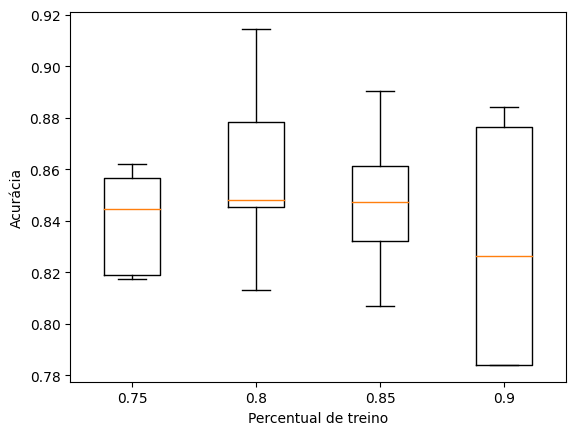

In [14]:


# train_ratio = [0.75, 0.8, 0.85, 0.9]
# iterations      = range(1, 6)

# accuracy_data = []
# x_labels = []

# for ratio in train_ratio:
#     accuracy = []
#     for i in iterations:
#         accuracy.append(classification_metrics_results[ratio][thresh_good[2]]['n_grains'][i]['accuracy'])
    
#     accuracy_data.append(accuracy)
#     # x_labels.append(int(ratio*100))
#     x_labels.append(ratio)

# plt.boxplot(accuracy_data, labels=x_labels)
# plt.xlabel('Percentual de treino')
# plt.ylabel('Acurácia')
# # plt.title('Accuracy Boxplot')
# plt.savefig('accuracy_boxplot_ngrains.pdf', dpi=300, bbox_inches='tight')
# plt.show()




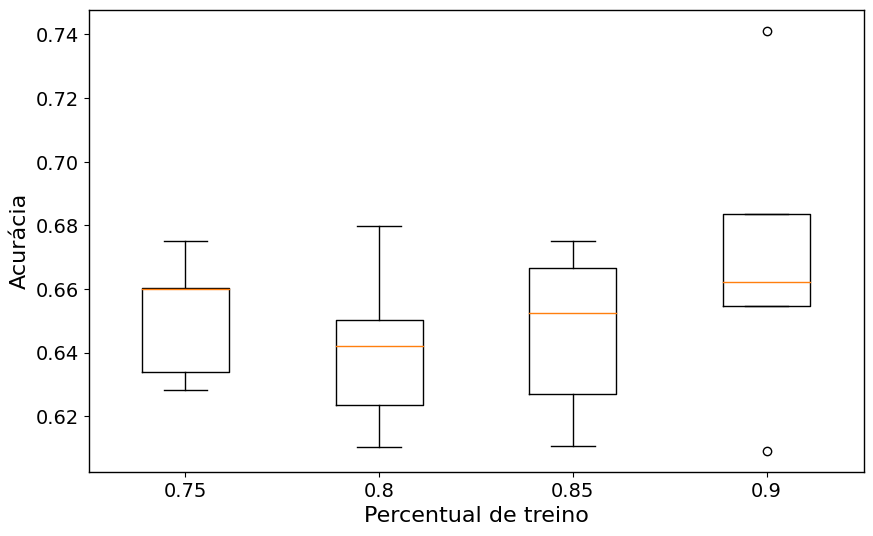

In [20]:
import matplotlib.pyplot as plt

train_ratio = [0.75, 0.8, 0.85, 0.9]
iterations = range(1, 6)

accuracy_data = []
x_labels = []

for ratio in train_ratio:
    accuracy = []
    for i in iterations:
        accuracy.append(classification_metrics_results[ratio][thresh_good[1]]['defect_stratified'][i]['accuracy'])

    accuracy_data.append(accuracy)
    x_labels.append(ratio)

# Set up the plot with the desired style
plt.figure(figsize=(10, 6))
plt.style.use('default')

# Create the boxplot
plt.boxplot(accuracy_data, labels=x_labels)

# Set the x and y axis labels
plt.xlabel('Percentual de treino', fontsize=16)
plt.ylabel('Acurácia', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Set the plot borders to black
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Remove gridlines
plt.grid(False)

# Save and display the plot
# plt.savefig('accuracy_boxplot_defect_stratified.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# train_ratio = [0.75, 0.8, 0.85, 0.9]

# accuracy_data = []
# x_labels = []

# for ratio in train_ratio:
#     accuracy = []
#     for i in iterations:
#         accuracy.append(classification_metrics_results[ratio][thresh_good[1]]['n_grains'][i]['accuracy'])
    
#     accuracy_data.append(accuracy)
#     x_labels.append(int(ratio*100))

# plt.boxplot(accuracy_data, labels=x_labels)
# plt.xlabel('Train Ratio')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Boxplot')

# # Set the y-axis range to show more values
# plt.ylim(0.7, 0.9)

# plt.show()


In [ ]:
# import pickle
# import pandas as pd

# with open("results/df_train.pkl", "rb") as f:
#     df_train = pickle.load(f)

# with open("results/df_test.pkl", "rb") as f:
#     df_test = pickle.load(f)



# df_train.to_csv("results/df_train.csv", index=False)
# df_test.to_csv("results/df_test.csv", index=False)

In [ ]:
cm = confusion_matrices[train_ratio[0]][thresh_good[1]]['n_grains']['mean']
display(cm)
export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_075_ngrains.png', [x_label, y_label])

cm = confusion_matrices[train_ratio[1]][thresh_good[1]]['n_grains']['mean']
# display(cm)
export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_080_ngrains.png', [x_label, y_label])

cm = confusion_matrices[train_ratio[2]][thresh_good[1]]['n_grains']['mean']
# display(cm)
export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_085_ngrains.png', [x_label, y_label])

cm = confusion_matrices[train_ratio[3]][thresh_good[1]]['n_grains']['mean']
# display(cm)
export_confusion_matrix_as_image(cm, classification_types['n_grains'], 'cm_090_ngrains.png', [x_label, y_label])


In [ ]:
import matplotlib.pyplot as plt

years = ['2017/18', '2018/19', '2019/20', '2020/21', '2021/22', '2022/23']
production = [80709.5, 100042.7, 102586.4, 87096.8, 114691.3, 125498.9]
importation = [900.7, 1596.4, 1453.4, 3090.7, 1900, 1500]
consumption = [59162, 64957.8, 68662.5, 72263.8, 77123.1, 81750]
exportation = [23742.2, 41074, 34892.9, 20815.7, 37500, 44500]

plt.plot(years, production, label='Produção')
plt.plot(years, importation, label='Importação')
plt.plot(years, consumption, label='Consumo')
plt.plot(years, exportation, label='Exportação')

plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Estatísticas')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

years = ['2017/18', '2018/19', '2019/20', '2020/21', '2021/22', '2022/23']
production = [80709.5, 100042.7, 102586.4, 87096.8, 114691.3, 125498.9]
importation = [900.7, 1596.4, 1453.4, 3090.7, 1900, 1500]
consumption = [59162, 64957.8, 68662.5, 72263.8, 77123.1, 81750]
exportation = [23742.2, 41074, 34892.9, 20815.7, 37500, 44500]

plt.bar(years, production, label='Produção')
plt.bar(years, importation, label='Importação')
plt.bar(years, consumption, label='Consumo')
plt.bar(years, exportation, label='Exportação')

plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Estatísticas')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

years = ['2017/18', '2018/19', '2019/20', '2020/21', '2021/22', '2022/23 (abr/23)', '2022/23 (mai/23)']
production = [80709.5, 100042.7, 102586.4, 87096.8, 124879.7, 124879.7, 125535.9]
importation = [900.7, 1596.4, 1453.4, 3090.7, 2615.1, 1900, 1900]
consumption = [59162, 64957.8, 68662.5, 72263.8, 74534.6, 79317, 79343.4]
exportation = [23742.2, 41074, 34892.9, 20815.7, 46630.3, 48000, 48000]

bar_width = 0.2
index = np.arange(len(years))

plt.bar(index, production, width=bar_width, label='Produção')
plt.bar(index + bar_width, importation, width=bar_width, label='Importação')
plt.bar(index + 2*bar_width, consumption, width=bar_width, label='Consumo')
plt.bar(index + 3*bar_width, exportation, width=bar_width, label='Exportação')

plt.xlabel('Safra', fontsize=14)
plt.ylabel('mil toneladas', fontsize=14)

plt.xticks(index + 1.5*bar_width, years, rotation=45, ha='right', fontsize=12)  # Increase spacing between x-axis labels
plt.yticks(fontsize=12)
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust the layout to prevent label overlapping
plt.savefig('dados_producao_milho.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# total = 312.5
# milho = 125535.9/1000

# milho/total *100


# milho

46630.3/124879.7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

years = ['2017/18', '2018/19', '2019/20', '2020/21', '2021/22', '2022/23']
categories = ['Produção', 'Importação', 'Consumo', 'Exportação']

data = np.array([
    [80709.5, 100042.7, 102586.4, 87096.8, 114691.3, 125498.9],
    [900.7, 1596.4, 1453.4, 3090.7, 1900, 1500],
    [59162, 64957.8, 68662.5, 72263.8, 77123.1, 81750],
    [23742.2, 41074, 34892.9, 20815.7, 37500, 44500]
])

width = 0.15  # Width of each bar
x = np.arange(len(years))  # X coordinate for each year

fig, ax = plt.subplots()

for i in range(len(categories)):
    ax.bar(x + (i - 1.5) * width, data[i], width=width, label=categories[i])

ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor')
ax.set_title('Estatísticas')
ax.legend()

plt.grid(True)
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the grayscale image
image = cv2.imread('img/dataset/pre_processada/gray/a1_60_1.jpg', 0)

# Calculate the histogram
histogram = cv2.calcHist([image], [0], None, [256], [10, 256])

# Plot the histogram
plt.figure()
plt.hist(image.ravel(), bins=256, range=[10, 256], color='gray')
plt.xlabel('Intensidade de Pixel', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.savefig('histograma_exemplo.pdf', dpi=300, bbox_inches='tight')


plt.show()
